### Import Required Packages and Set Options

#### Import Base Libraries

In [365]:
import os
import re
import sys
import git

import numpy as np
import numba as nb
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from functools import partial

In [366]:
sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Put the Main Package Library on the PYTHONPATH

In [367]:
git_repo = git.Repo('.', search_parent_directories=True)
git_root = git_repo.git.rev_parse('--show-toplevel')

sys.path[0] = git_root
sys.path[0]

'/Users/ericlundquist/Repos/rankfm'

#### Dynamically Re-Load all Package Modules on Execution

In [368]:
%load_ext autoreload
%autoreload 2

from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set File Path Constants

In [369]:
data_path = os.path.join(git_root, "data/ml-1m")
print("\n".join([git_root, data_path]))

/Users/ericlundquist/Repos/rankfm
/Users/ericlundquist/Repos/rankfm/data/ml-1m


### Prepare Example Data

#### Load Users Data

In [370]:
user_columns = ['user_id', 'gender', 'agegrp', 'occupation', 'zipcode']
users_df = pd.read_csv(os.path.join(data_path, "users.dat"), sep="::", engine="python", names=user_columns, header=None)
users_df = users_df.drop(['zipcode'], axis=1)
users_df = pd.get_dummies(users_df, prefix_sep='__', columns=['gender', 'agegrp', 'occupation'])
users_df.info()
users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 31 columns):
user_id           6040 non-null int64
gender__F         6040 non-null uint8
gender__M         6040 non-null uint8
agegrp__1         6040 non-null uint8
agegrp__18        6040 non-null uint8
agegrp__25        6040 non-null uint8
agegrp__35        6040 non-null uint8
agegrp__45        6040 non-null uint8
agegrp__50        6040 non-null uint8
agegrp__56        6040 non-null uint8
occupation__0     6040 non-null uint8
occupation__1     6040 non-null uint8
occupation__2     6040 non-null uint8
occupation__3     6040 non-null uint8
occupation__4     6040 non-null uint8
occupation__5     6040 non-null uint8
occupation__6     6040 non-null uint8
occupation__7     6040 non-null uint8
occupation__8     6040 non-null uint8
occupation__9     6040 non-null uint8
occupation__10    6040 non-null uint8
occupation__11    6040 non-null uint8
occupation__12    6040 non-null uint8
occupation__13    6

,user_id,gender__F,gender__M,agegrp__1,agegrp__18,agegrp__25,agegrp__35,agegrp__45,agegrp__50,agegrp__56,...,occupation__11,occupation__12,occupation__13,occupation__14,occupation__15,occupation__16,occupation__17,occupation__18,occupation__19,occupation__20
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,3,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Load Items Data

In [371]:
item_columns = ['item_id', 'title', 'genres']
items_df = pd.read_csv(os.path.join(data_path, "movies.dat"), sep="::", engine="python", names=item_columns, header=None)

genres = items_df['genres'].str.split('|').tolist()
genres = sorted(list(set([genre for movie in items_df['genres'].str.split('|').tolist() for genre in movie])))
print("list of all genres: {}".format(genres))

for genre in genres:
    items_df[re.sub('[^a-z]', '', genre.lower())] = items_df['genres'].str.contains(genre).astype(np.int32)
    
items_df.info()
items_df.head()

list of all genres: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 21 columns):
item_id        3883 non-null int64
title          3883 non-null object
genres         3883 non-null object
action         3883 non-null int32
adventure      3883 non-null int32
animation      3883 non-null int32
childrens      3883 non-null int32
comedy         3883 non-null int32
crime          3883 non-null int32
documentary    3883 non-null int32
drama          3883 non-null int32
fantasy        3883 non-null int32
filmnoir       3883 non-null int32
horror         3883 non-null int32
musical        3883 non-null int32
mystery        3883 non-null int32
romance        3883 non-null int32
scifi          3883 non-null int32
thriller       3883 non-null int32
war  

,item_id,title,genres,action,adventure,animation,childrens,comedy,crime,documentary,...,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Load Ratings Data

In [372]:
ratings_columns = ['user_id', 'item_id', 'rating', 'unix_timestamp']
ratings_explicit = pd.read_csv(os.path.join(data_path, "ratings.dat"), sep="::", engine="python", names=ratings_columns, header=None)
ratings_explicit['timestamp'] = pd.to_datetime(ratings_explicit['unix_timestamp'], origin='unix', unit='s')
ratings_explicit = ratings_explicit.drop('unix_timestamp', axis=1)

ratings_explicit.info()
ratings_explicit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
item_id      1000209 non-null int64
rating       1000209 non-null int64
timestamp    1000209 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.5 MB


,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


#### Generate Implicit Feedback Ratings Data

In [373]:
ratings_implicit = ratings_explicit[ratings_explicit.rating >= 4].reset_index(drop=True)
ratings_implicit.info()
ratings_implicit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575281 entries, 0 to 575280
Data columns (total 4 columns):
user_id      575281 non-null int64
item_id      575281 non-null int64
rating       575281 non-null int64
timestamp    575281 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 17.6 MB


,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,3408,4,2000-12-31 22:04:35
2,1,2355,5,2001-01-06 23:38:11
3,1,1287,5,2000-12-31 22:33:59
4,1,2804,5,2000-12-31 22:11:59


#### Print Final Matrix Shapes

In [374]:
print("users:", ratings_explicit.user_id.nunique(), "items:", ratings_explicit.item_id.nunique())
print("users:", ratings_implicit.user_id.nunique(), "items:", ratings_implicit.item_id.nunique())

print(ratings_explicit.shape)
print(ratings_implicit.shape)

users: 6040 items: 3706
users: 6038 items: 3533
(1000209, 4)
(575281, 4)


#### Evaluate Sparsity

#### Create (Training, Validation) Interactions for Evaluation

In [375]:
print(ratings_explicit.shape)
ratings_explicit.head()

(1000209, 4)


,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [379]:
np.random.seed(1492)
ratings = ratings_explicit #.sample(n=100000)
ratings['random'] = np.random.random(size=len(ratings))
test_pct = 0.25

In [380]:
sparsity = 1 - (len(ratings) / (ratings.user_id.nunique() * ratings.item_id.nunique()))
round(100 * sparsity, 2)

95.53

In [410]:
train_mask = ratings['random'] <  (1 - test_pct)
valid_mask = ratings['random'] >= (1 - test_pct)

interactions_total = ratings[['user_id', 'item_id']]
interactions_train = ratings[train_mask][['user_id', 'item_id']]
interactions_valid = ratings[valid_mask][['user_id', 'item_id']]

train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

train_items = np.sort(interactions_train.item_id.unique())
valid_items = np.sort(interactions_valid.item_id.unique())

print("total shape: {}".format(interactions_total.shape))
print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))

print("train users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

print("train items: {}".format(len(train_items)))
print("valid items: {}".format(len(valid_items)))

total shape: (1000209, 2)
train shape: (749724, 2)
valid shape: (250485, 2)
train users: 6040
valid users: 6038
cold-start users: set()
train items: 3666
valid items: 3531


In [382]:
iteraction_users = interactions_train.user_id.unique()
iteraction_items = interactions_train.item_id.unique()

#### Create User/Item Features Data for Testing

In [383]:
user_features = users_df[users_df.user_id.isin(iteraction_users)]
print(user_features.shape, users_df.shape)
user_features.head()

(6040, 31) (6040, 31)


,user_id,gender__F,gender__M,agegrp__1,agegrp__18,agegrp__25,agegrp__35,agegrp__45,agegrp__50,agegrp__56,...,occupation__11,occupation__12,occupation__13,occupation__14,occupation__15,occupation__16,occupation__17,occupation__18,occupation__19,occupation__20
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,3,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [384]:
item_features = items_df[items_df.item_id.isin(iteraction_items)].drop(['title', 'genres'], axis=1)
print(item_features.shape, items_df.shape)
item_features.head()

(3666, 19) (3883, 21)


,item_id,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Test Out Core Package Functionality

In [385]:
interactions_train.shape, user_features.shape, item_features.shape

((749724, 2), (6040, 31), (3666, 19))

In [386]:
interactions_train.dtypes

user_id    int64
item_id    int64
dtype: object

#### Fit the Model on the Training Data and Profile Computational Performance

In [388]:
model = RankFM(factors=10, regularization=0.01, sigma=0.1, learning_rate=0.10, learning_schedule='invscaling', learning_exponent=0.25)
model

In [389]:
%%time

model.fit(interactions_train, epochs=40, verbose=True)
# model.fit(interactions_train, item_features=item_features, epochs=20, verbose=True)


training epoch: 0
log likelihood: -296008.38

training epoch: 1
log likelihood: -261466.02

training epoch: 2
log likelihood: -231553.01

training epoch: 3
log likelihood: -214243.19

training epoch: 4
log likelihood: -204247.6

training epoch: 5
log likelihood: -197855.61

training epoch: 6
log likelihood: -193889.88

training epoch: 7
log likelihood: -189970.01

training epoch: 8
log likelihood: -187806.01

training epoch: 9
log likelihood: -185936.28

training epoch: 10
log likelihood: -183980.94

training epoch: 11
log likelihood: -183227.32

training epoch: 12
log likelihood: -181924.77

training epoch: 13
log likelihood: -181316.53

training epoch: 14
log likelihood: -180312.9

training epoch: 15
log likelihood: -179620.26

training epoch: 16
log likelihood: -179283.27

training epoch: 17
log likelihood: -178828.49

training epoch: 18
log likelihood: -179185.44

training epoch: 19
log likelihood: -178100.81

training epoch: 20
log likelihood: -177636.06

training epoch: 21
log l

In [390]:
# model.fit_partial(interactions_train, epochs=5, verbose=True)

#### Generate Model Scores

In [391]:
%%time
scores = model.predict(interactions_train, cold_start='nan') 

CPU times: user 1.51 s, sys: 26.8 ms, total: 1.54 s
Wall time: 886 ms


In [392]:
%%time
scores = model.predict(interactions_valid, cold_start='nan') 

CPU times: user 893 ms, sys: 10.6 ms, total: 904 ms
Wall time: 300 ms


#### Generate TopN Recommendations

In [393]:
train_users = pd.Series(interactions_train.user_id.unique())
valid_users = pd.Series(interactions_valid.user_id.unique())

len(train_users), len(valid_users), len(set(valid_users) - set(train_users))

(6040, 6038, 0)

In [394]:
%%time
top_recs = model.recommend_for_users(valid_users, n_items=10, filter_previous=False, cold_start='nan')

CPU times: user 7.75 s, sys: 56.1 ms, total: 7.81 s
Wall time: 2 s


In [395]:
top_recs.head()

,0,1,2,3,4,5,6,7,8,9
1,34,595,2081,2324,919,1,318,364,2396,588
2,457,590,608,2028,1610,527,3256,1721,1183,1617
3,1196,589,480,2716,1197,1270,2916,1136,2571,1291
4,541,589,1214,1196,1240,480,924,750,1127,1210
5,2599,2858,3481,2997,608,2336,1885,2571,223,2959


### Evaluate Model Performance on the Validation Data

#### Specify Number of Recommended Items

In [396]:
k = 10

#### Generate Pure-Popularity Baselines

In [397]:
most_popular = interactions_train.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

item_id
2858    2545
260     2254
1196    2230
1210    2178
589     2002
2028    1980
480     1974
1270    1939
2571    1921
608     1910
Name: user_id, dtype: int64

In [398]:
test_user_items = interactions_valid.groupby('user_id')['item_id'].apply(set).to_dict()
test_recommends = model.recommend_for_users(list(test_user_items.keys()), cold_start='drop')
test_user_items = {key: val for key, val in test_user_items.items() if key in test_recommends.index}

base_pre = round(np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()]), 3)
base_rec = round(np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()]), 3)

print("number of test users: {}".format(len(test_user_items)))
print("baseline precision: {}".format(base_pre))
print("baseline recall: {}".format(base_rec))

number of test users: 6038
baseline precision: 0.116
baseline recall: 0.046


#### Generate Model Performance Validation Metriccs

In [399]:
%%time
model_hit_rate = hit_rate(model, interactions_valid, k=k)

CPU times: user 9.6 s, sys: 73.1 ms, total: 9.68 s
Wall time: 3.38 s


In [400]:
%%time
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)

CPU times: user 11.5 s, sys: 59.4 ms, total: 11.6 s
Wall time: 5.36 s


In [401]:
%%time
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)

CPU times: user 11.5 s, sys: 55.2 ms, total: 11.6 s
Wall time: 5.37 s


In [402]:
%%time
model_precision = precision(model, interactions_valid, k=k)

CPU times: user 10 s, sys: 45.4 ms, total: 10.1 s
Wall time: 3.85 s


In [403]:
%%time
model_recall = recall(model, interactions_valid, k=k)

CPU times: user 9.46 s, sys: 48.8 ms, total: 9.5 s
Wall time: 3.24 s


In [404]:
print("hit_rate: {}".format(round(model_hit_rate, 3)))
print("reciprocal_rank: {}".format(round(model_reciprocal_rank, 3)))
print("dcg: {}".format(round(model_dcg, 3)))
print("precision: {}".format(round(model_precision, 3)))
print("recall: {}".format(round(model_recall, 3)))

hit_rate: 0.765
reciprocal_rank: 0.329
dcg: 0.703
precision: 0.152
recall: 0.068


#### Generate Item Diversity DataFrame

In [406]:
model_diversity = diversity(model, interactions_valid, k=k)
model_diversity.head(10)

,item_id,cnt_users,pct_users
0,480,1982,0.328254
1,589,1882,0.311693
2,608,1831,0.303246
3,2858,1706,0.282544
4,1196,1535,0.254223
5,2762,1517,0.251242
6,2716,1416,0.234515
7,2571,1287,0.213150
8,1270,1184,0.196091
9,1617,1118,0.185161


In [411]:
top_items = pd.merge(items_df, model_diversity, on='item_id', how='inner')
top_items = top_items.set_index('item_id').loc[model_diversity.item_id[:10]].reset_index()

top_items = top_items[['item_id', 'cnt_users', 'pct_users', 'title', 'genres']]
top_items

,item_id,cnt_users,pct_users,title,genres
0,480,1982,0.328254,Jurassic Park (1993),Action|Adventure|Sci-Fi
1,589,1882,0.311693,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
2,608,1831,0.303246,Fargo (1996),Crime|Drama|Thriller
3,2858,1706,0.282544,American Beauty (1999),Comedy|Drama
4,1196,1535,0.254223,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
5,2762,1517,0.251242,"Sixth Sense, The (1999)",Thriller
6,2716,1416,0.234515,Ghostbusters (1984),Comedy|Horror
7,2571,1287,0.213150,"Matrix, The (1999)",Action|Sci-Fi|Thriller
8,1270,1184,0.196091,Back to the Future (1985),Comedy|Sci-Fi
9,1617,1118,0.185161,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller


In [412]:
coverage = np.mean(model_diversity['cnt_users'] > 0)
round(coverage, 3)

0.244

In [413]:
nonzero = model_diversity[model_diversity.cnt_users > 0]
entropy = -np.sum(nonzero['pct_users'] * np.log2(nonzero['pct_users']))
round(entropy, 2)

42.1

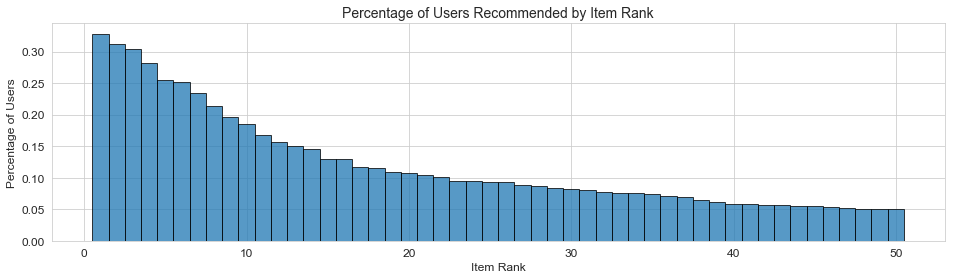

In [414]:
fig, axes = plt.subplots(1, 1, figsize=[16, 4])
N = 50

topN = model_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

### QA the Predict/Recommend/Similarity Methods

#### Generate Model Scores for Test User/Items

In [415]:
mask = (interactions_valid.user_id.isin(interactions_train.user_id)) & (interactions_valid.item_id.isin(interactions_train.item_id))
print(interactions_valid.shape)
print(interactions_valid[mask].shape)

(250485, 2)
(250437, 2)


In [416]:
scores_miss = model.predict(interactions_valid, cold_start='nan')
scores_drop = model.predict(interactions_valid, cold_start='drop')

print(scores_miss.shape)
print(scores_drop.shape)

(250485,)
(250437,)


#### Spot-Check Some User Recommendations

In [417]:
len(train_users), len(valid_users), cold_start_users

(6040, 6038, set())

In [418]:
recommendations = model.recommend_for_users(valid_users, n_items=10, filter_previous=True, cold_start='nan')
print(recommendations.shape)
recommendations.head(10)

(6038, 10)


,0,1,2,3,4,5,6,7,8,9
1,34,2081,2324,1,318,364,2396,1265,1282,356
2,590,608,1610,527,1721,1183,1617,3418,377,1221
3,589,2716,1197,2916,2571,457,2028,2628,110,608
4,541,589,1196,480,924,750,1127,1210,1270,1200
5,2599,3481,2336,2571,223,1653,2692,1748,3160,1639
6,2424,2724,1028,1270,1721,1269,2396,3114,356,11
7,589,2916,457,2571,2028,2628,608,2353,1200,1210
8,1183,2028,3100,778,593,300,1271,318,2762,1617
9,593,1617,2997,318,356,296,2396,3481,589,457
10,1270,2096,2018,34,594,1029,1022,2716,3114,364


In [421]:
user_id = 5
user_recs = recommendations.loc[user_id]
user_item_names = items_df[items_df.item_id.isin(user_recs)].set_index('item_id').loc[user_recs].reset_index()
user_item_names[['item_id', 'title', 'genres']]

,item_id,title,genres
0,2599,Election (1999),Comedy
1,3481,High Fidelity (2000),Comedy
2,2336,Elizabeth (1998),Drama
3,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
4,223,Clerks (1994),Comedy
5,1653,Gattaca (1997),Drama|Sci-Fi|Thriller
6,2692,Run Lola Run (Lola rennt) (1998),Action|Crime|Romance
7,1748,Dark City (1998),Film-Noir|Sci-Fi|Thriller
8,3160,Magnolia (1999),Drama
9,1639,Chasing Amy (1997),Drama|Romance


#### Look at Similar Movies for a Few Recommended Movies

In [422]:
most_similar_items = model.similar_items(1748)
most_similar_names = items_df.set_index('item_id').loc[most_similar_items].reset_index()
most_similar_names[['item_id', 'title', 'genres']]

,item_id,title,genres
0,741,Ghost in the Shell (Kokaku kidotai) (1995),Animation|Sci-Fi
1,1909,"X-Files: Fight the Future, The (1998)",Mystery|Sci-Fi|Thriller
2,1215,Army of Darkness (1993),Action|Adventure|Comedy|Horror|Sci-Fi
3,29,"City of Lost Children, The (1995)",Adventure|Sci-Fi
4,1653,Gattaca (1997),Drama|Sci-Fi|Thriller
5,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6,198,Strange Days (1995),Action|Crime|Sci-Fi
7,2393,Star Trek: Insurrection (1998),Action|Sci-Fi
8,1921,Pi (1998),Sci-Fi|Thriller
9,196,Species (1995),Horror|Sci-Fi


### Look at the Movies with the Highest/Lowest Model Weights

In [423]:
item_weights = pd.DataFrame({'item_idx': np.arange(len(model.w_i)), 'w_item': model.w_i})
item_weights['item_id'] = item_weights['item_idx'].map(model.index_to_item)

item_weights = pd.merge(item_weights, items_df, on='item_id').sort_values('w_item', ascending=False)
item_weights = item_weights[['item_id', 'item_idx', 'title', 'w_item']]

#### Best Movies Ever?

In [424]:
item_weights.head(10)

,item_id,item_idx,title,w_item
2624,2858,2624,American Beauty (1999),1.551298
462,480,462,Jurassic Park (1993),1.531829
570,589,570,Terminator 2: Judgment Day (1991),1.531769
587,608,587,Fargo (1996),1.498322
1468,1617,1468,L.A. Confidential (1997),1.491250
1092,1196,1092,Star Wars: Episode V - The Empire Strikes Back...,1.485734
2485,2716,2485,Ghostbusters (1984),1.473584
1164,1270,1164,Back to the Future (1985),1.469525
2530,2762,2530,"Sixth Sense, The (1999)",1.459026
1827,2028,1827,Saving Private Ryan (1998),1.412589


#### Worst Movies Ever?

In [239]:
item_weights.tail(10)

,item_id,item_idx,title,w_item
128,134,128,Sonic Outlaws (1995),-2.040172
560,579,560,"Scorta, La (1993)",-2.041980
3087,3353,3087,"Closer You Get, The (2000)",-2.059445
124,130,124,Angela (1995),-2.061026
2369,2592,2369,"Joyriders, The (1999)",-2.067927
1028,1118,1028,Tashunga (1995),-2.069583
721,774,721,Wend Kuuni (God's Gift) (1982),-2.074341
572,591,572,Tough and Deadly (1995),-2.090299
1311,1430,1311,Underworld (1997),-2.090967
2841,3085,2841,"Living Dead Girl, The (La Morte Vivante) (1982)",-2.140156


# Start Sandbox Code